In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import pandas as pd
from tensorflow.keras.backend import sigmoid
import numpy as np

def swish(x, beta = 1):
    # https://www.geeksforgeeks.org/ml-swish-function-by-google-in-keras/
    return (x * sigmoid(beta * x))
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.25)
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
def weighted_loss(y_true, y_pred):
    return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)

def image_convert(a):
    new = np.zeros((30, 30))
    for i in range(30):
        if int(a[i]*100)==0:
            d = 29
        elif int(a[i]*100)==100:
            d = 0
        else:
            d = 30-int(30-(1-a[i])*30)
            if d==30:
                d = 29
        new[d, i] = 1
    return new

get_custom_objects().update({'swish': swish})
get_custom_objects().update({'leaky_relu': leaky_relu})
get_custom_objects().update({"get_weighted_loss": get_weighted_loss})
get_custom_objects().update({"weighted_loss": weighted_loss})

In [5]:
banana_X_train = pd.read_pickle("banana_X_train.pkl")
banana_X_val = pd.read_pickle("banana_X_val.pkl")
banana_Y_train = pd.read_pickle("banana_Y_train.pkl")
banana_Y_val = pd.read_pickle("banana_Y_val.pkl")
cols_name = [[y+'-'+str(x).rjust(2,"0") for x in range(1,31)] for y in ['RSV','上價中位數','下價中位數','中價中位數','交易量','平均價','雨量']]
cols_name_2 = [x for x in banana_X_train.columns.tolist() if '-' not in x]

train_X_num = banana_X_train[cols_name_2[1:]].values
val_X_num = banana_X_val[cols_name_2[1:]].values

train_Y_1 = banana_Y_train[[x for x in banana_Y_train.columns if '成本價格' in x]].values
val_Y_1 = banana_Y_val[[x for x in banana_Y_val.columns if '成本價格' in x]].values

train_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_train[cols_name[i]].iloc[:,-7:]
    train_X_lstm_1.append(tmp)
train_X_lstm_1 = np.stack(train_X_lstm_1,axis=2)
val_X_lstm_1 = []
for i in range(len(cols_name)):
    tmp = banana_X_val[cols_name[i]].iloc[:,-7:]
    val_X_lstm_1.append(tmp)
val_X_lstm_1 = np.stack(val_X_lstm_1,axis=2)

train_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_train[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    train_X_lstm_2.append(tmp_all)
train_X_lstm_2 = np.stack(train_X_lstm_2,axis=3)

val_X_lstm_2 = []
for i in range(len(cols_name)):
    tmp_all = []
    tmp = banana_X_val[cols_name[i]].iloc[:,-13:]
    for j in range(7):
        tmp_1 = tmp.iloc[:,j:j+7]
        tmp_all.append(tmp_1)
    tmp_all = np.stack(tmp_all,axis=2)
    val_X_lstm_2.append(tmp_all)
val_X_lstm_2 = np.stack(val_X_lstm_2,axis=3)

train_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_train[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)
val_X_lstm_4 = np.stack([np.stack([image_convert(x) for x in banana_X_val[cols_name[y]].values]) for y in range(len(cols_name))], axis=3)

data_X = {'Conv1D':[train_X_lstm_1, val_X_lstm_1],
          'Vanilla':[train_X_lstm_1, val_X_lstm_1],
          'Stacked':[train_X_lstm_1, val_X_lstm_1],
          'Bidirectional':[train_X_lstm_1, val_X_lstm_1],
          'Conv1D_LSTM':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_1':[train_X_lstm_2, val_X_lstm_2],
          'Conv2D_2':[train_X_lstm_4, val_X_lstm_4]}

In [44]:
weight = 'model/Conv1D_LSTM/0.0001-sgd-swish-relu/weights_accuracy.hdf5'
model = load_model(weight)
data_train = model.predict([data_X["Conv1D_LSTM"][1],val_X_num], verbose = 0)

before = banana_Y_val[['成本價格-02', '成本價格-03', '成本價格-04', '成本價格-05', '成本價格-06']].values
after = data_train

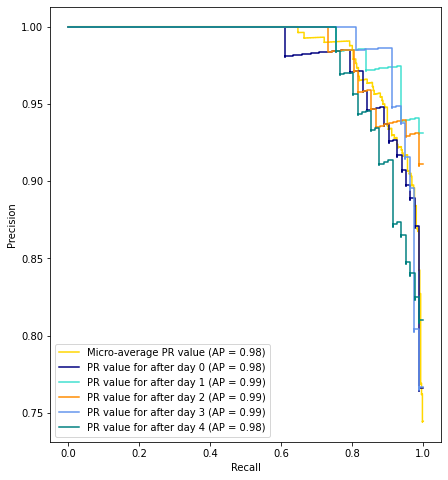

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(7, 8))

# For each class
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

precision = dict()
recall = dict()
average_precision = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(before[:, i], after[:, i])
    average_precision[i] = average_precision_score(before[:, i], after[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    before.ravel(), after.ravel()
)
average_precision["micro"] = average_precision_score(before, after, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average PR value", color="gold")

for i, color in zip(range(5), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"PR value for after day {i}", color=color)